## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

# Assignment 1, Task 1: Basic Classifiers

In this task, you are going to implement two classifers and apply them to the **Fashion-MNIST** dataset: 

(1) Logistic Regression (LR) classifier

(2) Softmax classifier

In [1]:
# Import modules, make sure you have installed all required packages before you start.
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Module auto reloading. (Ref: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html)
%load_ext autoreload
%autoreload 2

## Load Fashion-MNIST Dataset

[**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist) is a widely used dataset mainly used for benchmarking the very basic machine learning models. Images are drawn from Zalando's clothing articles and the dataset consists of a training set with 60,000 examples and a test set with 10,000 examples. Each example is a $28 \times 28$ pixel grayscale image with an associated label from 10 classes. We will use this to create our training set, validation set, and test set.

First, we load the raw Fashion-MNIST data to create a 10-class dataset and manually define a label map.

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

# the integer labels in y_train and y_test correspond to the index of this label map
label_map = [
    't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

# Here we vectorize the data (rearranged the shape of images) for you. 
# That is, we flatten 28×28 2D images into 784 1D arrays.
# The reason we do this is that we can not put 2D image representations into our model. 
# This is a common practice (flattening images before putting them into the ML models). 
# Note that this isn't the usual practice for Convolutional Neural Networks (CNN). 
# We will see how we manage the data with CNNs in later assignments.

# Check the results
print('Raw training data shape: ', X_train_raw.shape)
print('Raw test data shape: ', X_test_raw.shape)

# API Reference: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
# In practice, you would ALWAYS want to consult the documentations for API usage.
X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

num_classes = max(y_train) + 1

print('Number of classes: ', num_classes)
print('Vectorized training data shape: ', X_train.shape)
print('Vectorized test data shape: ', X_test.shape)
print('Training labels shape: ', y_train.shape)
print('Test labels shape: ', y_test.shape)

Raw training data shape:  (60000, 28, 28)
Raw test data shape:  (10000, 28, 28)
Number of classes:  10
Vectorized training data shape:  (60000, 784)
Vectorized test data shape:  (10000, 784)
Training labels shape:  (60000,)
Test labels shape:  (10000,)


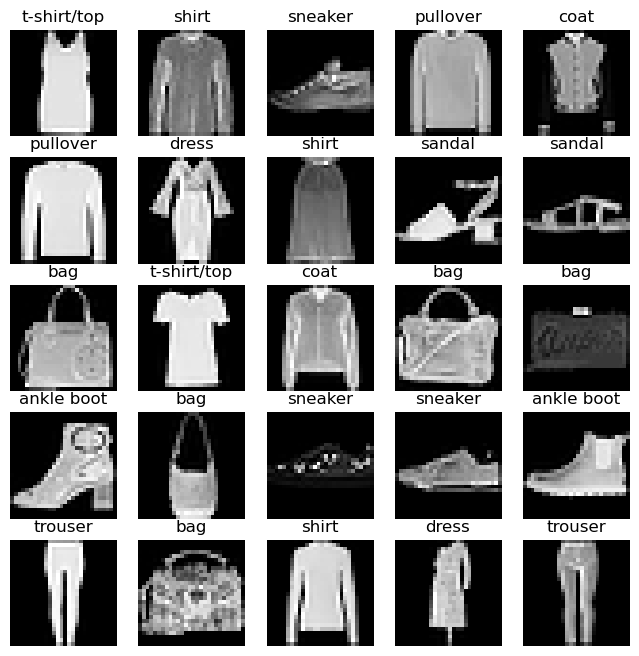

In [4]:
# Let's randomly select 25 images from the training set for visualization.
ids = np.random.randint(X_train_raw.shape[0], size=25).reshape((5, 5))

# Visualize Fashion-MNIST data.
fig, axes1 = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axes1[i][j].set_axis_off()
        axes1[i][j].imshow(X_train_raw[ids[i][j]], cmap='gray')
        axes1[i][j].set_title(label_map[y_train[ids[i][j]]])

In [3]:
# Data organization:
#    Training data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the training set: indices 1~49,000
#    Development data (binary) (only for gradient check in Part 1): 100 random samples from the binary training set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100
num_dev_binary = 100

# For numpy slicing operations, refer to
# https://numpy.org/doc/stable/user/basics.indexing.html
X_train = X_train[:num_training, :]
y_train = y_train[:num_training]
X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]
X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

ids_dev = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[ids_dev]
y_dev = y_train[ids_dev]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (1000, 784)
Test labels shape:  (1000,)
Development data shape: (100, 784)
Development data shape (100,)


Next, we subsample the whole (10-class) dataset to obtain the binary (2-class) dataset for LR classifier.

In [4]:
# Subsample 10-class training set to 2-class training set
X_train_binary = X_train[y_train<2,:]
y_train_binary = y_train[y_train<2]

X_val_binary = X_val[y_val<2,:]
y_val_binary = y_val[y_val<2]

ids_dev_binary = np.random.choice(X_train_binary.shape[0], num_dev_binary, replace=False)
X_dev_binary = X_train_binary[ids_dev_binary]
y_dev_binary = y_train_binary[ids_dev_binary]

print('Train data (binary) shape: ', X_train_binary.shape)
print('Train labels (binary) shape: ', y_train_binary.shape)
print('Validation data (binary) shape: ', X_val_binary.shape)
print('Validation labels (binary) shape: ', y_val_binary.shape)
print('Development data (binary) shape:', X_dev_binary.shape)
print('Development labels (binary) shape', y_dev_binary.shape)

Train data (binary) shape:  (9775, 784)
Train labels (binary) shape:  (9775,)
Validation data (binary) shape:  (217, 784)
Validation labels (binary) shape:  (217,)
Development data (binary) shape: (100, 784)
Development labels (binary) shape (100,)


### Preprocessing

As a preparation, let's normalize the input data:
* Training data is 2D with shape `[num_training=49,000, dim=784]`.
* Obtain the **mean** ($\mu$) and **standard deviation** ($\sigma$) of all samples.
* For every training sample, subtract the mean and divide by the standard deviation.

The ***normalized*** training data $X$ now has a standard form of $\mu (X) = 0$ and $\sigma (X) = 1$. We will revisit input normalization in detail in later assignments. For short, the intuition here is to eliminate the effect of input range on the model.

<font color="red"><strong>Note</strong></font>: We always use the statistics from the training to normalize validation & test sets.

In [5]:
# For the original dataset
# Please, for yourself, search and understand the usage of common numpy APIs.
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train.astype(np.float32) - mean) / std
X_val = (X_val.astype(np.float32) - mean) / std
X_test = (X_test.astype(np.float32) - mean) / std
X_dev = (X_dev.astype(np.float32) - mean) / std

# For the binary dataset
mean_bin = np.mean(X_train_binary, axis=0)
std_bin = np.std(X_train_binary, axis=0)

X_train_binary = (X_train_binary.astype(np.float32) - mean_bin) / std_bin
X_val_binary = (X_val_binary.astype(np.float32) - mean_bin) / std_bin
X_dev_binary = (X_dev_binary.astype(np.float32) - mean_bin) / std_bin

print('Train data mean: ', np.mean(X_train))
print('Train data std: ', np.std(X_train))
print('Validation data mean: ', np.mean(X_val))
print('Validation data std: ', np.std(X_val))
print('Test data mean: ', np.mean(X_test))
print('Test data std: ', np.std(X_test))
print('Train data (binary) mean: ', np.mean(X_train_binary))
print('Train data (binary) std: ', np.std(X_train_binary))
print('Validation data (binary) mean: ', np.mean(X_val_binary))
print('Validation data (binary) std: ', np.std(X_val_binary))
print('Development data (binary) mean: ', np.mean(X_dev_binary))
print('Development data (binary) std: ', np.std(X_dev_binary))

Train data mean:  1.0653701993904043e-18
Train data std:  1.0000000000000049
Validation data mean:  0.000632053572125212
Validation data std:  0.9858059379386237
Test data mean:  0.011770124978117812
Test data std:  0.9920003542330077
Train data (binary) mean:  1.0829295831825736e-18
Train data (binary) std:  1.0000000000000009
Validation data (binary) mean:  0.0025070824611815538
Validation data (binary) std:  1.0016797720563086
Development data (binary) mean:  -0.028161287804672638
Development data (binary) std:  0.8496218534368807


## Part 0: Basics

In this part, you are going to get familiar with one of the very basic modeling methodologies of classification problems. 

<font color="red"><strong>Note</strong></font>: Without further specifications, all vectors mentioned are considered ***column*** vectors. 

Let’s consider a training dataset of $N$ images. Each of the images $x_i$ has an associated label $y_i \in \{1, \dots, K\}$, where $i = \{1, \dots, N\}$ and $K$ represents the number of distinct classes.

Assume that all images have shape `[H(eight), W(idth), C(hannels)]`, a ***flattened*** image can be denoted as

$$
x_i \in R^D \quad \text{where} \quad D = H \times W \times C
$$

And we construct the dataset $(X, y)$ as

$$
X = \begin{bmatrix} x_1^T \\ \vdots \\ x_N^T \end{bmatrix} \in R^{N \times D}, \quad
y = \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix} \in R^N
$$

For the Fashion-MNIST dataset as an example, we have training data `X_train` with shape `[49000,784]` and the corresponding labels `y_train` with shape `[49000,]`. Here the number of input images $N = 49000$, and each image has a flattened shape of $D = 28 \times 28 \times 1 = 784$. The total number of classes is $K = 10$.

## Part 1: Logistic Regression Classifier (10 pts)

In this part, you are going to implement a Logistic Regression (LR) classifier. 

#### 1. Problem Definition

Logistic Regression classifier can solve a binary classification problem that has only two classes. Therefore, it is reasonable for us to model only one of the two classes. Specifically, we develop a model that try to assign the samples to one class, and those sample that cannot be assigned should be considered as the other class [3].

To put it mathematically, consider some sample $x_i \in X$ with the corresponding binary label $y_i = \{0, 1\}$. We study the ***likelihood*** of this sample belonging to class "$1$" under model parameter $w$, i.e. $P(y_i = 1 | x_i, w)$.

#### 2. Formulation

Consider a ***linear*** score function $f: R^D \to R$ that takes in a sample $x_i$ and computes a class score (also called a "***logit***")

$$f(x_i; w, b) := w^T x_i + b$$

where $w \in R^D$ contains the weights and $b \in R$ is the bias.

The LR model is defined to be a mapping from a sample $x_i \in R^D$ to the probability

$$P(y_i = 1 | x_i, w) := \sigma (f_i) = \frac{1}{1 + e^{-f_i}}$$

where $f_i = f(x_i; w, b)$ and $\sigma: R \to (0, 1)$ is the [`sigmoid`](https://en.wikipedia.org/wiki/Sigmoid_function) function.

To make life easier, we use the ***bias trick*** to represent the two parameters ($w, b$) as one by the two following steps:
1. Extend the vector $x_i$ with one additional constant $1$
$$x_i \gets [x_i; 1] \in R^{D + 1}$$
2. Concatenate the original weights $w$ and biases $b$ together to form a new weight vector
$$w \gets [w; b] \in R^{D + 1}$$

Without changing the notations, the score function simplifies to

$$f(x_i; w) = w^T x_i$$

where we have $w, x_i \in R^{D + 1}$. Indeed, this is a ***homogeneous*** representation of the linear system.

Therefore, the likelihood predicted by the LR model is defined as

$$P(y_i = 1 | x_i, w) = \sigma(f_i) = \frac{1}{1 + e^{-w^T x_i}}$$

With the mappings defined above, a sample $x_i$ can be classified by setting a probability threashold $T = 0.5$. Pariticularly, we predict a sample $x_i$ to be of class "$1$" if 

$$P(y_i = 1 | x_i, w) > T$$

It is easy to show that this is equivalent to $f_i > 0$.

#### 3. Optimization

Our model can now make predictions on input samples in $R^{D + 1}$. We can thus evaluate the quality of the predictions.

For some $x_i$, the likelihood of our model making ***correct*** predictions (same as the ground truth) can be given by

$$
P(y_i | x_i, w) = \begin{cases} 
p_i & \text{if } y_i = 1 \\ 
1 - p_i & \text{otherwise } (\text{i.e. } y_i = 0)
\end{cases}
$$

where $p_i = P(y_i = 1 | x_i, w)$.

It is not hard to show that this equation can then be re-written in a more compact form [3] as

$$P(y_i | x_i, w) = p_i^{y_i} (1 - p_i)^{1 - y_i}$$

You can simply verify this by plugging in $y_i = 0$ and $y_i = 1$.

To obtain a good model, we can estimate the parameter $w$ such that our model can achieve the maximum likelihood of making correct predictions over all samples. This is called the ***Maximum Likelihood Estimation (MLE)***.

Assume all $x_i$ are [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), we seek to maximize the joint likelihood, i.e.

$$\max_w P(y | X, w)$$

where $P(y | X, w) = \Pi_{i=1}^N P(y_i|x_i,w)$.

This is immediately equivalent to maximizing the joint ***log-likelihood***, which reads

$$
\begin{aligned}
l(w)
:&= \ln P(y | X, w) \\
&= \sum_{i=1}^N y_i \ln p_i + (1 - y_i) \ln (1 - p_i) \\
\end{aligned}
$$

The equivalence follows from the monotonicity of logarithms, i.e. whichever $w$ that maximizes $P$ should also maximize $\ln P$.

All we have to solve is the following optimization problem

$$
\min_w L(w; X, y) \quad \text{s.t.} \quad L(w; X, y) =  - \frac{1}{N} L(w) + \frac{\lambda}{2} \|w\|^2
$$

where $\lambda$ is the regularization factor. This is an $L_2$ regularization since we're introducing an $L_2$ norm of the parameter $w$ in to the objective.

Indeed, the function $L$ is more commonly know as the ***binary cross-entropy*** loss.

There is no analytic solution to the problem in general. Nonetheless, we can find the optimum by ***Gradient Descent***.

One can calculate

$$\nabla_w L = - \frac{1}{N} \sum_{i=1}^N (y_i - p_i) x_i + \lambda w$$

For a clearer notation,

$$
\nabla_w L = - \frac{1}{N} X^T (y - p) + \lambda w
\quad \text{where} \quad
p := \begin{bmatrix} p_1 \\ \vdots \\ p_N \end{bmatrix}
$$

Recall that $X \in R^{N \times (D + 1)}$, and the gradient $\nabla_w L \in R^{D + 1}$ must be of the same shape with the parameter $w$.

<font color="red"><strong>Note</strong></font>: This solution is valid due to the ***convexity*** of our formulation in nature. It is worth keeping in mind that gradient methods DO NOT guarantee the optimal solution for non-convex problems.

Feel free to explore these useful links:

[1] https://web.stanford.edu/~jurafsky/slp3/5.pdf

[2] https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac

[3] Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction. 2nd ed. New York: Springer.

<font color="red"><strong>TODO</strong></font>: Based on the derivations given above, complete the code in `./utils/classifiers/logistic_regression.py`. You have to implement the classifier in two ways: 

* Naive method using for-loop: Loop over and compute each element
* Vectorized method: Use the NumPy vector/matrix operations

We provide the verification code for you to check if your implementation is correct. 

<font color="red"><strong>Hint</strong></font>:
* Do not forget the $L_2$ regularization term in the loss function and the gradients.
* Be aware of the data types. It is a good habit to avoid any numerical computations between different data types.

A Tensorflow implementation of LR is demonstrated in the verification code below. This step will familiarize you with TensorFlow functions.

<font color="red"><strong>Note</strong></font>: Please do not change the code in the cell below.

In [8]:
# Verification code for checking the correctness of the implementation of logistic_regression
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT

from utils.classifiers.logistic_regression import logistic_regression_loss_naive
from utils.classifiers.logistic_regression import logistic_regression_loss_vectorized

# Generate initial weight vector
w = np.random.randn(X_train.shape[1]) * 0.0001
reg = 0.000005

# Naive numpy implementation of Logistic Regression
loss_naive, grad_naive = logistic_regression_loss_naive(w, X_dev_binary, y_dev_binary, reg)

# Vectorized numpy implementation of Logistic Regression
loss_vec, grad_vec = logistic_regression_loss_vectorized(w, X_dev_binary, y_dev_binary, reg)

# True value computed by tf
# Here we specify float64 because this is the default float type in numpy
# A usual float32 may result in inconsistancy due to floating point error
w_tf = tf.Variable(w, dtype=tf.float64)
with tf.GradientTape() as tape:
     tape.watch(w_tf)
     # loss calculation:        use a tf.nn loss function
     loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          tf.Variable(y_dev_binary, dtype=tf.float64), 
          # do w@x
          tf.linalg.matvec(tf.Variable(X_dev_binary, dtype=tf.float64), w_tf)
          # regularization
     )) + reg * tf.nn.l2_loss(w_tf)
     # gradient calculation
     grad_true = tape.gradient(loss_true, w_tf)

## Check the correctness
print('naive numpy loss: {}.'.format(loss_naive))
print('vectorized numpy loss: {}.'.format(loss_vec))
print('true loss: {}'.format(loss_true))
print('*'*100)
print('Relative naive gradient error is {}'.format(np.linalg.norm(grad_naive - grad_true)))
print('Relative vectorized gradient error is {}'.format(np.linalg.norm(grad_vec - grad_true)))
print('*'*100)
print('Is naive loss correct? {}'.format(np.allclose(loss_naive, loss_true)))
print('Is naive gradient correct? {}'.format(np.allclose(grad_naive, grad_true)))
print('Is vectorized loss correct? {}'.format(np.allclose(loss_vec, loss_true)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_vec, grad_true)))

naive numpy loss: 0.6936306458310098.
vectorized numpy loss: 0.6936306458310102.
true loss: 0.6936306458310102
****************************************************************************************************
Relative naive gradient error is 2.1135087092723107e-15
Relative vectorized gradient error is 2.116446900741086e-15
****************************************************************************************************
Is naive loss correct? True
Is naive gradient correct? True
Is vectorized loss correct? True
Is vectorized gradient correct? True


## Part 2: Softmax Classifier (10 pts)

Softmax classifier generalizes the Logistic Regression classifier to multiple classes.

In the Softmax classifier, the score function is a mapping from a sample $x_i \in R^{D + 1}$ to $K$ different class scores, i.e.

$$f_{i,k} = w_k^T x_i \quad \forall k \in \{1, \dots, K\}$$

Or equivalently, we have $f: R^{D + 1} \to R^K$

$$
\begin{aligned}
f(x_i; W) 
&:= \begin{bmatrix} f_{i,1} \\ \vdots \\ f_{i,K} \end{bmatrix}
= \begin{bmatrix} w_1^T x_i \\ \vdots \\ w_K^T x_i \end{bmatrix}
= W^T x_i \\
&\text{where} \quad
W = [w_1, \dots, w_K] \in R^{(D + 1) \times K}
\end{aligned}
$$

Notice that this is also a homogeneous representation where we've already applied the bias trick.

In order to obtain the predicted probabilities over $K$ classes, here we introduce the [`softmax`](https://en.wikipedia.org/wiki/Softmax_function) function $\sigma: R^K \to (0, 1)^K$

$$\sigma (s) := \frac{e^s}{\sum_{k=1}^K e^{s_k}}$$

Indeed, the softmax function results in a probability distribution, i.e. $\sum_k \sigma (s)_k = 1$.

And the predicted distribution for sample $x_i$ can be defined as

$$P(y_i | x_i, W) := \sigma (f_i) = \frac{e^{f_i}}{\sum_{k=1}^K e^{f_{i,k}}}$$

where $f_i = f(x_i; W)$.

Similarly, we have to measure the quality of our predictions.

For some (discrete) distributions $q, r \in R^K$, consider

$$H(q, r) := -\mathbb{E}_q [\ln r] = -\sum_{k = 1}^K q_k \ln r_k$$

This real-valued function is called the [***cross-entropy***](https://en.wikipedia.org/wiki/Cross-entropy), which can be regarded as a ***dissimilarity metric*** between $p$ and $q$.

For some sample $x_i$, the target distribution derived from the corresponding label $y_i \in \{1, \dots, K\}$ can be constructed using [***one-hot encoding***](https://en.wikipedia.org/wiki/One-hot), which reads

$$
\begin{aligned}
\begin{matrix} 
g_i := &[ &0, &\dots, &0, &\underline{\underline{1}}, &0, &\dots, &0 &] \in R^K \\
& &1\text{-st} &\dots & &y_i\text{-th} &\dots & &K\text{-th} &
\end{matrix} \\
\end{aligned}
$$

The ideal distribution only takes $1$ at the $y_i$-th position and has $0$ everywhere else. The dissimilarity between prediction $p_i := P(y_i | x_i, W)$ and target $g_i$ is then $H(g_i, p_i) = -g_i^T \ln p_i$.

Intuitively, we optimize the model parameter $W$ by minimizing the dissimilarity between predictions and targets over all samples, i.e.

$$
\min_W L(W; X, y) \quad \text{s.t.} \quad
L(W; X, y) = \frac{1}{N} \sum_{i = 1}^N H(g_i, p_i) + \frac{\lambda}{2} \|W\|_F^2
$$

This is indeed one of the most widely used classification loss known as the ***categorical cross-entroy***.

Here, $\|W\|_F = \sqrt{\sum_{k,i} |w_{k,i}|^2}$ is the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm). It is easy to see that

$$\|W\|_F^2 = \sum_k \|w_k\|^2$$

which corresponds to the sum of the $L_2$ norms of weights $w_k$ of every class from $1$ to $K$.

And the gradient follows  

$$
\nabla_{w_k} L= \frac{1}{N} \sum_i (p_{i,k} - g_{i,k}) x_i + \lambda w_k
\quad \forall k \in \{1, \dots, K\}
$$

Or equivalently, 

$$
\begin{aligned}
\nabla_W L &= \frac{1}{N} X^T (P - G) + \lambda W \\
&\text{where} \quad
G = \begin{bmatrix} g_1^T \\ \vdots \\ g_N^T \end{bmatrix} \in R^{N \times K},
P = \begin{bmatrix} p_1^T \\ \vdots \\ p_N^T \end{bmatrix} \in R^{N \times K}
\end{aligned}
$$

And obviously, $\nabla_W L \in R^{(D + 1) \times K}$

<font color="red"><strong>NOTE</strong></font>: **Numerical Stability**. When you are writing code for computing the `softmax` function in practice, the intermediate terms $e^s$ and $\sum_k e^{s_k}$ may be very large due to the exponentials. Division with large numbers can be numerically unstable, so it is important to use the normalization trick. 

Notice that if we multiply both the top and the bottom of the fraction by constant $C$ and push $C$ inside the exponent, we get the following equivalent expression: 

$$
\sigma (s)
= \frac{e^s}{\sum_k e^{s_k}}
= \frac{C e^s}{C \sum_k e^{s_k}}
= \frac{e^{s + \ln C}}{\sum_k e^{s_k + \ln C}}
$$

A common choice for $C$ is to set $\ln C= -\max_i s_i$ to be the maximum among all components of $s$.

<font color="red"><strong>TODO</strong></font>: Based on the derivations above, complete the code in **./utils/classifiers/softmax.py**. You have to implement the classifier in two ways: 

* Naive method using for-loop: Loop over and compute each element
* Vectorized method: Use the NumPy vector/matrix operations

We provide the verification code for you to check if your implementation is correct. 

<font color="red"><strong>Hint:</strong></font>
* Do not forget the $L_2$ regularization term in the loss function and the gradients.
* Be aware of the data types. It is a good habit to avoid any numerical computations between different data types.

A Tensorflow implementation of Softmax classifier is demonstrated in the verification code below.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below.

In [9]:
# Verification code for checking the correctness of the implementation of softmax implementations
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.softmax import softmax_loss_naive
from utils.classifiers.softmax import softmax_loss_vectorized

## generate a random weight matrix of small numbers
W = np.random.randn(X_train.shape[1], num_classes) * 0.0001
reg = 0.000005

## naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc - tic))

## vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc - tic))

# true value computed by tf
W_tf = tf.Variable(W, dtype = tf.float64)
tic = time.time()
with tf.GradientTape() as tape:
    tape.watch(W_tf)
    loss_true = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        tf.one_hot(tf.Variable(y_dev, dtype=tf.int32), num_classes), 
        tf.matmul(tf.Variable(X_dev, dtype=tf.float64), W_tf)
    )) + reg * tf.nn.l2_loss(W_tf)
    grad_true = tape.gradient(loss_true, W_tf)
toc = time.time()
print('true loss: {}, takes {} seconds'.format(loss_true, toc - tic))

## check the correctness
print('*'*100)
print('Relative loss error of naive softmax is {}'.format(np.linalg.norm(loss_true - loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(np.linalg.norm(loss_true - loss_vec)))
print('Gradient error of naive softmax is {}'.format(np.linalg.norm(grad_true - grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(np.linalg.norm(grad_true - grad_vec)))
print('*'*100)
print('Is naive softmax loss correct? {}'.format(np.allclose(loss_true, loss_naive)))
print('Is vectorized softmax loss correct? {}'.format(np.allclose(loss_true, loss_vec)))
print('Is naive softmax grad correct? {}'.format(np.allclose(grad_true, grad_naive,1e-02)))
print('Is vectorized softmax grad correct? {}'.format(np.allclose(grad_true, grad_vec,1e-02)))

naive numpy loss: 2.3028723402462736, takes 0.00379180908203125 seconds.
vectorized numpy loss: 2.302872340246273, takes 0.0005698204040527344 seconds.
true loss: 2.302872340246273, takes 0.025090694427490234 seconds
****************************************************************************************************
Relative loss error of naive softmax is 4.440892098500626e-16
Relative loss error of vectorized softmax is 0.0
Gradient error of naive softmax is 2.271724524692762e-15
Gradient error of vectorized softmax is 2.2495612629079815e-15
****************************************************************************************************
Is naive softmax loss correct? True
Is vectorized softmax loss correct? True
Is naive softmax grad correct? True
Is vectorized softmax grad correct? True


## Part 3: Train your classifiers (5 pts)

Now you can start to train your classifiers. Due to the fact that both the logistic regression and softmax classifer does not admit an analytical solution, we are going to use gradient descent algorithm for training. 

In the training section, you are asked to implement gradient descent optimization method, which can be interpreted as an attempt to minimize the loss function following iterative update of the model parameters using 

$$w \gets w - \alpha \nabla_w L$$

where $\alpha$ is the learning rate, and $\nabla_w L$ is the gradient of the loss $L$ w.r.t the parameter $w$. 

<font color="red"><strong>TODO</strong></font>: The code template is given in `./utils/classifiers/basic_classifier.py`. You need to complete functions `train` and `predict`, in the class `BasicClassifier`. Later you will need to use its subclasses `LogisticRegression` and `Softmax` to train the two models seperately and verify your result.

### Train Logistic Regression + Stochastic Gradient Descent (SGD)

<font color="red"><strong>TODO</strong></font>: Complete the code of subclasses `LogisticRegression` in **./utils/classifiers/basic_classifiers.py**. 

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [12]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.basic_classifiers import LogisticRegression

## The bias trick
# We concatenate to every data point an extra dimension of 1
X_train_binary_b = np.hstack([X_train_binary, np.ones((X_train_binary.shape[0], 1))])
X_val_binary_b = np.hstack([X_val_binary, np.ones((X_val_binary.shape[0], 1))])
X_dev_binary_b = np.hstack([X_dev_binary, np.ones((X_dev_binary.shape[0], 1))])

## Logistic Regression + SGD
classifier = LogisticRegression()
reg = 1e-3 # regularization
lr = 1e-5 # learning rate

loss_hist_sgd = classifier.train(
    X_train_binary_b, y_train_binary, 
    learning_rate=lr, reg=reg, 
    num_iters=3000, optim='SGD', 
    verbose=True
)

# Write the BasicClassifier.predict function and evaluate the performance 
# on both training set and validation set
y_train_pred = classifier.predict(X_train_binary_b)
print('training accuracy:', np.mean(y_train_binary == y_train_pred))
y_val_pred = classifier.predict(X_val_binary_b)
print('validation accuracy:', np.mean(y_val_binary == y_val_pred))

iteration 0 / 3000: loss 0.691518
iteration 100 / 3000: loss 0.667389
iteration 200 / 3000: loss 0.641139
iteration 300 / 3000: loss 0.621903
iteration 400 / 3000: loss 0.597267
iteration 500 / 3000: loss 0.578188
iteration 600 / 3000: loss 0.568201
iteration 700 / 3000: loss 0.559922
iteration 800 / 3000: loss 0.536490
iteration 900 / 3000: loss 0.522723
iteration 1000 / 3000: loss 0.512034
iteration 1100 / 3000: loss 0.505064
iteration 1200 / 3000: loss 0.473280
iteration 1300 / 3000: loss 0.468155
iteration 1400 / 3000: loss 0.441360
iteration 1500 / 3000: loss 0.441028
iteration 1600 / 3000: loss 0.435586
iteration 1700 / 3000: loss 0.430781
iteration 1800 / 3000: loss 0.427022
iteration 1900 / 3000: loss 0.421969
iteration 2000 / 3000: loss 0.412787
iteration 2100 / 3000: loss 0.410719
iteration 2200 / 3000: loss 0.402512
iteration 2300 / 3000: loss 0.403760
iteration 2400 / 3000: loss 0.371140
iteration 2500 / 3000: loss 0.378030
iteration 2600 / 3000: loss 0.361320
iteration 270

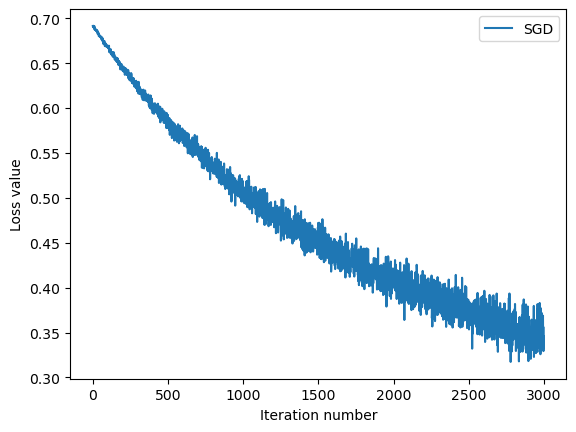

In [13]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train Softmax + SGD

<font color="red"><strong>TODO</strong></font>: Complete the code of subclasses **Softmax** in **./utils/classifiers/basic_classifier.py**.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [14]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.basic_classifiers import Softmax

## The bias trick
# We concatenate to every data point an extra dimension of 1
X_train_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val_b = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev_b = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

## Softmax + SGD
classifier = Softmax()
reg = 1e-3 # regularization
lr = 1e-5 # learning rate
loss_hist_sgd = classifier.train(
    X_train_b, y_train, 
    learning_rate=lr, reg=reg, 
    num_iters=3000, optim='SGD', 
    verbose=True
)

# Write the BasicClassifier.predict function and evaluate the performance 
# on both the training and validation set
y_train_pred = classifier.predict(X_train_b)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val_b)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 3000: loss 2.290189
iteration 100 / 3000: loss 2.266558
iteration 200 / 3000: loss 2.242566
iteration 300 / 3000: loss 2.225439
iteration 400 / 3000: loss 2.194299
iteration 500 / 3000: loss 2.176843
iteration 600 / 3000: loss 2.154838
iteration 700 / 3000: loss 2.113696
iteration 800 / 3000: loss 2.109810
iteration 900 / 3000: loss 2.082271
iteration 1000 / 3000: loss 2.062639
iteration 1100 / 3000: loss 2.065248
iteration 1200 / 3000: loss 2.022846
iteration 1300 / 3000: loss 1.995436
iteration 1400 / 3000: loss 1.992134
iteration 1500 / 3000: loss 1.973193
iteration 1600 / 3000: loss 1.950337
iteration 1700 / 3000: loss 1.977668
iteration 1800 / 3000: loss 1.950456
iteration 1900 / 3000: loss 1.921054
iteration 2000 / 3000: loss 1.884805
iteration 2100 / 3000: loss 1.829678
iteration 2200 / 3000: loss 1.854492
iteration 2300 / 3000: loss 1.851192
iteration 2400 / 3000: loss 1.815370
iteration 2500 / 3000: loss 1.813751
iteration 2600 / 3000: loss 1.782286
iteration 270

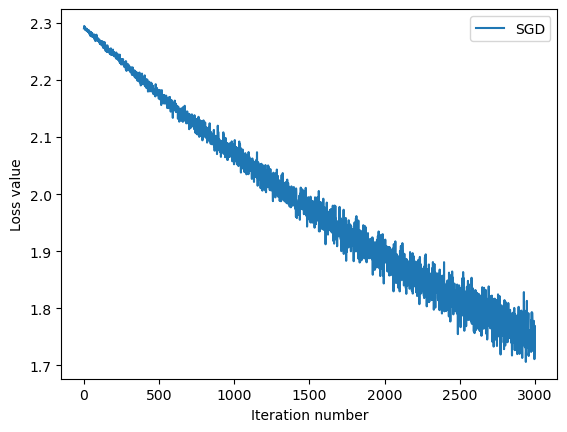

In [15]:
## SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()